In [1]:
# Add the source directory to the path
import sys
sys.path.append('/home/sleyse4/repos/LoRE_SD/LoRE-SD/src')
sys.path.append('/home/sleyse4/repos/LoRE_SD/LoRE-SD')

import os
import subprocess
import shutil

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import gradient_utils, plot_utils, io_utils, math_utils
from optimisation import optimise

import contrasts

from mrtrix_io.io import load_mrtrix, save_mrtrix
from mrtrix_io.io.image import Image

import utils.SphericalHarmonics as sh

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.transforms import Bbox

In [200]:
def normalise_0_1(vals):
    return (vals - np.min(vals)) / (np.max(vals) - np.min(vals))

# Define decreasing functions
def sigmoid_function(vals, reverse=False, k=20, x0=0.15):
    if not reverse:
        return normalise_0_1(np.array([1 - 1 / (1 + np.exp(-k * (j - x0))) for j in normalise_0_1(vals)]))
    else:
        return normalise_0_1(np.array([1 - 1 / (1 + np.exp(-k * (vals[-1] - (j - x0)))) for j in normalise_0_1(vals)]))

def exponential_decay_function(vals, reverse=False, rate=2):
    if not reverse:
        return normalise_0_1(np.array([np.exp(-rate * j) for j in normalise_0_1(vals)]))
    else:
        return normalise_0_1(np.array([np.exp(-rate * (vals[-1] - j)) for j in normalise_0_1(vals)]))

def inverse_linear_function(vals, reverse=False, scale=2):
    if not reverse:
        return normalise_0_1(np.array(np.clip([1 - scale * j for j in normalise_0_1(vals)], 0, 1)))
    else:
        return normalise_0_1(np.array(np.clip([1 - scale * (vals[-1] - j) for j in normalise_0_1(vals)], 0, 1)))

In [201]:
def to_decay_matrix(ad, rd, decay_function, axis='radial', with_isotropic=True, **kwargs):
    unit_matrix = ad[:, None] >= rd[None] if with_isotropic else ad[:, None] > rd[None]
    if axis == 'radial':
        dec = decay_function(rd, **kwargs)
        dec = np.repeat(dec[None], repeats=len(ad), axis=0)
    elif axis == 'axial':
        dec = decay_function(ad, **kwargs)
        dec = np.repeat(dec[:, None], repeats=len(rd), axis=1)
    else:
        raise ValueError('Axis must be either "radial" or "axial"')
    return unit_matrix * dec

def to_contrast(fractions, ad, rd, decay_function, axis='radial', with_isotropic=True, reverse=False, **kwargs):
    decay_matrix = to_decay_matrix(ad, rd, decay_function, axis=axis, with_isotropic=with_isotropic, reverse=reverse, **kwargs)
    return np.sum(fractions * decay_matrix, axis=(-1,-2))


In [202]:
ad = np.linspace(0, 4e-3, 10)
rd = np.linspace(0, 4e-3, 10)

In [221]:
fractions = load_mrtrix('/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/sub-PT015/LoRE/gaussian_fractions.mif').data
vox = load_mrtrix('/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/sub-PT015/LoRE/gaussian_fractions.mif').vox

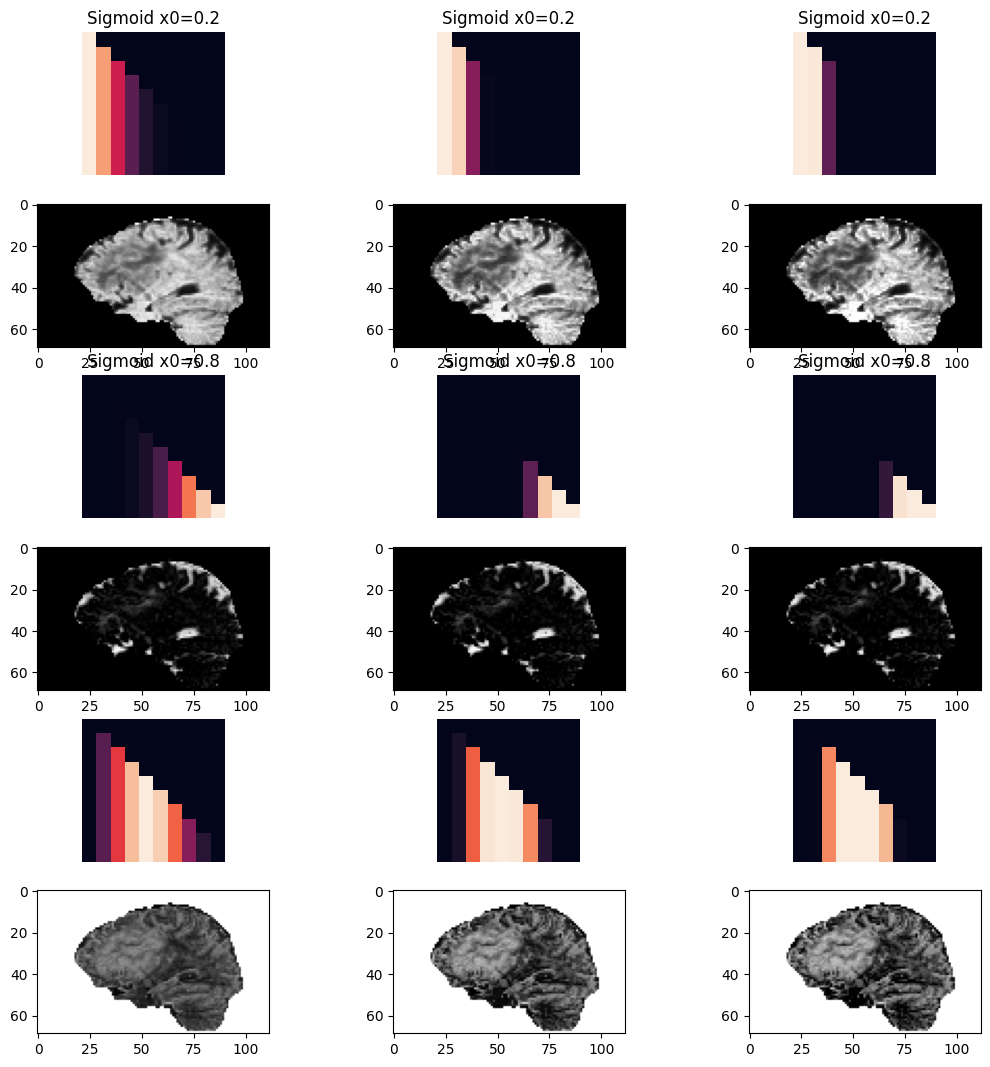

In [237]:
# Sigmoid plots
fig, axs = plt.subplots(6, 3, figsize=(13, 13))
x = .2
 
for i, k in enumerate(np.linspace(10, 50, 3)):
    hm_wm = axs[0, i]
    wm_matrix = to_decay_matrix(ad, rd, sigmoid_function, with_isotropic=True, x0=x, k=k)
    sns.heatmap(wm_matrix, ax=hm_wm, square=True, annot=False, cbar=False)
    hm_wm.set_title(f'Sigmoid x0={x}')
    hm_wm.set_xticks([])
    hm_wm.set_yticks([])
    
    ax_wm = axs[1, i]
    wm_contrast = to_contrast(fractions, ad, rd, sigmoid_function, with_isotropic=True, x0=x, k=k)
    ax_wm.imshow(np.fliplr(np.rot90(wm_contrast[70])), cmap='gray')

    csf_matrix = to_decay_matrix(ad, rd, sigmoid_function, with_isotropic=True, x0=.7, k=k, reverse=True)
    hm_csf = axs[2, i]
    sns.heatmap(csf_matrix, ax=hm_csf, square=True, annot=False, cbar=False)
    hm_csf.set_title(f'Sigmoid x0={1-x}')
    hm_csf.set_xticks([])
    hm_csf.set_yticks([])

    ax_csf = axs[3, i]
    csf_contrast = to_contrast(fractions, ad, rd, sigmoid_function, with_isotropic=True, x0=.7, k=k, reverse=True)
    ax_csf.imshow(np.fliplr(np.rot90(csf_contrast[70])), cmap='gray')

    gm_matrix = (1 - wm_matrix - csf_matrix)*(ad[:, None] >= rd[None])
    hm_gm = axs[4, i]
    sns.heatmap(gm_matrix, ax=hm_gm, square=True, annot=False, cbar=False)
    hm_gm.set_xticks([])
    hm_gm.set_yticks([])

    ax_gm = axs[5, i]
    gm_contrast = 1 - wm_contrast - csf_contrast
    ax_gm.imshow(np.fliplr(np.rot90((1 - wm_contrast - csf_contrast)[70])), cmap='gray')

    save_mrtrix(f'/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/sub-PT015/LoRE/sigmoid_wm_{k}.mif', Image(wm_contrast, vox=vox))
    save_mrtrix(f'/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/sub-PT015/LoRE/sigmoid_csf_{k}.mif', Image(csf_contrast, vox=vox))
    save_mrtrix(f'/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/sub-PT015/LoRE/sigmoid_gm_{k}.mif', Image(gm_contrast, vox=vox))



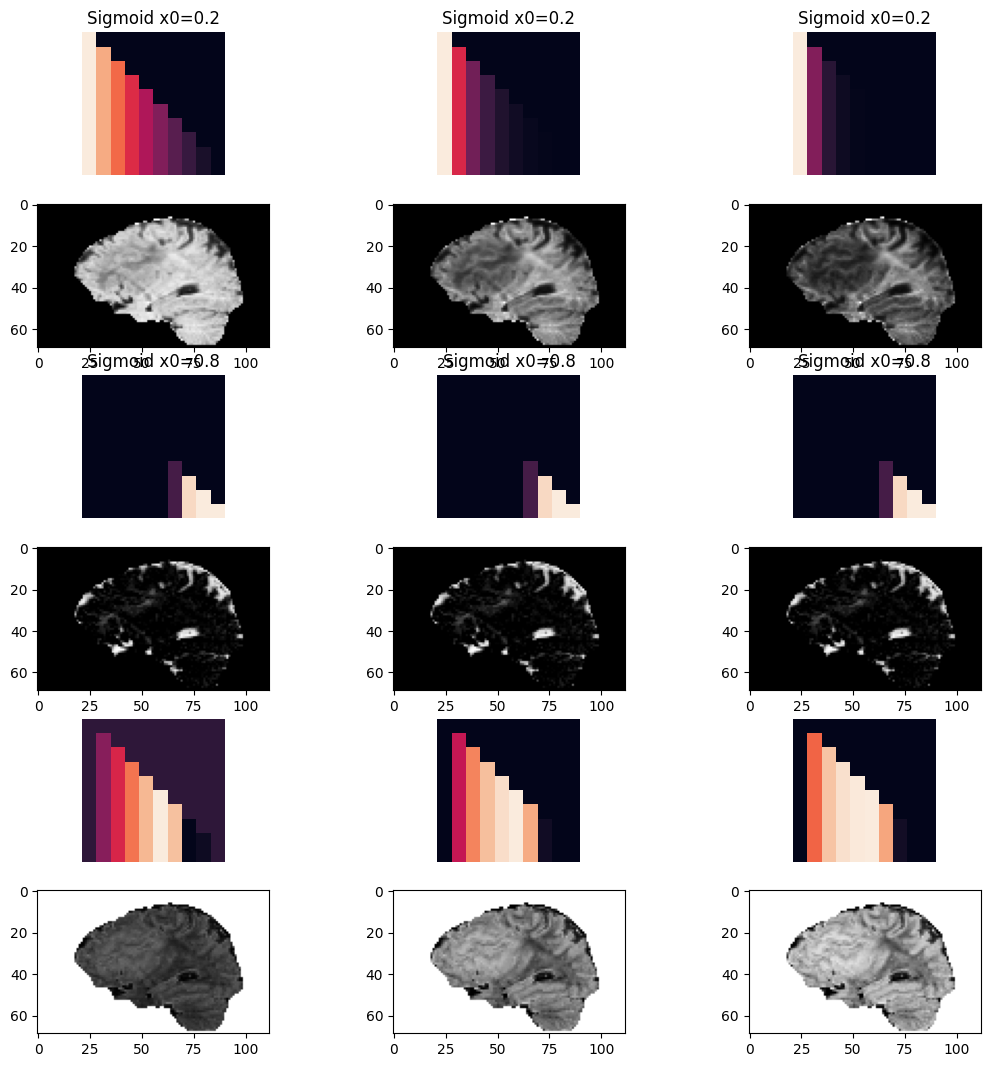

In [239]:
# Sigmoid plots
fig, axs = plt.subplots(6, 3, figsize=(13, 13))
for i, e in enumerate(np.linspace(1, 10, 3)):
    hm_wm = axs[0, i]
    wm_matrix = to_decay_matrix(ad, rd, exponential_decay_function, with_isotropic=True, rate=e)
    sns.heatmap(wm_matrix, ax=hm_wm, square=True, annot=False, cbar=False)
    hm_wm.set_title(f'Sigmoid x0={x}')
    hm_wm.set_xticks([])
    hm_wm.set_yticks([])
    
    ax_wm = axs[1, i]
    wm_contrast = to_contrast(fractions, ad, rd, exponential_decay_function, with_isotropic=True, rate=e)
    ax_wm.imshow(np.fliplr(np.rot90(wm_contrast[70])), cmap='gray')

    csf_matrix = to_decay_matrix(ad, rd, sigmoid_function, with_isotropic=True, x0=.7, k=40, reverse=True)
    hm_csf = axs[2, i]
    sns.heatmap(csf_matrix, ax=hm_csf, square=True, annot=False, cbar=False)
    hm_csf.set_title(f'Sigmoid x0={1-x}')
    hm_csf.set_xticks([])
    hm_csf.set_yticks([])

    ax_csf = axs[3, i]
    sf_contrast = to_contrast(fractions, ad, rd, sigmoid_function, with_isotropic=True, x0=.7, k=40, reverse=True)
    ax_csf.imshow(np.fliplr(np.rot90(csf_contrast[70])), cmap='gray')

    gm_matrix = (1 - wm_matrix - csf_matrix)*(ad[:, None] >= rd[None])
    hm_gm = axs[4, i]
    sns.heatmap(gm_matrix, ax=hm_gm, square=True, annot=False, cbar=False)
    hm_gm.set_xticks([])
    hm_gm.set_yticks([])

    ax_gm = axs[5, i]
    gm_contrast = 1 - wm_contrast - csf_contrast
    ax_gm.imshow(np.fliplr(np.rot90((1 - wm_contrast - csf_contrast)[70])), cmap='gray')
    
    save_mrtrix(f'/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/sub-PT015/LoRE/exponential_wm_{e}.mif', Image(wm_contrast, vox=vox))
    save_mrtrix(f'/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/sub-PT015/LoRE/exponential_csf_{e}.mif', Image(csf_contrast, vox=vox))
    save_mrtrix(f'/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/sub-PT015/LoRE/exponential_gm_{e}.mif', Image(gm_contrast, vox=vox))
